## Data Preparation 

In [22]:
# Standard Library
import os
import time
import random
from typing import List, Dict, Tuple, Protocol


# Third-Party Libraries
import numpy as np
import pandas as pd

import cv2
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import patches

from skimage.feature import hog, graycomatrix, graycoprops

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity


# Dataset Paths
DATA_DIR_COREL = "D:\\Trade-Off_CBIR\\dataset\\Corel-1K"
DATA_DIR_GHIM  = "D:\\Trade-Off_CBIR\\dataset\\GHIM-10K"

print("Classes available (Corel-1K):", os.listdir(DATA_DIR_COREL))
print("Classes available (GHIM-10K):", os.listdir(DATA_DIR_GHIM))


Classes available (Corel-1K): ['africans', 'beaches', 'buildings', 'buses', 'dinosaurs', 'elephants', 'flowers', 'food', 'horses', 'mountains']
Classes available (GHIM-10K): ['aircraft', 'buildings', 'butterfly', 'cars', 'dragon fly', 'fireworks', 'flowers', 'hen', 'horses', 'insects', 'motorcycles', 'mountains', 'sea shores', 'ships', 'sunset', 'temples', 'trees', 'valleys', 'walls', 'yacht']


## Dataset: Corel-1K

### Tahap 1: Model Initialization

In [23]:
# Encoder Interface (for type checking & clarity)
class Encoder(Protocol):
    def forward(self, img: Image.Image) -> np.ndarray:
        ...


# Preprocessing Utility
def preprocess(
    img: Image.Image,
    target_size: tuple[int, int] = (128, 128)
) -> np.ndarray:
    """
    Resize + CLAHE grayscale preprocessing
    """
    img_np = cv2.resize(np.array(img), target_size)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)


# Classical Feature Extractors
def extract_hog(img: np.ndarray) -> np.ndarray:
    return hog(
        img,
        orientations=12,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    ).astype(np.float32)


def extract_glcm(img: np.ndarray, levels: int = 32) -> np.ndarray:
    img_q = np.floor(img / (256 / levels)).astype(np.uint8)

    glcm = graycomatrix(
        img_q,
        distances=[1, 2, 3],
        angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
        levels=levels,
        symmetric=True,
        normed=True
    )

    props = [
        "contrast",
        "dissimilarity",
        "homogeneity",
        "energy",
        "correlation",
        "ASM"
    ]

    feat = []
    for p in props:
        feat.extend(graycoprops(glcm, p).ravel())

    return np.asarray(feat, dtype=np.float32)


def extract_gist(img: np.ndarray) -> np.ndarray:
    feats = []
    thetas = [
        0, np.pi / 6, np.pi / 4, np.pi / 3,
        np.pi / 2, 2 * np.pi / 3, 3 * np.pi / 4, 5 * np.pi / 6
    ]

    for theta in thetas:
        kernel = cv2.getGaborKernel(
            ksize=(31, 31),
            sigma=4.0,
            theta=theta,
            lambd=10.0,
            gamma=0.5,
            psi=0
        )
        filtered = cv2.filter2D(img, cv2.CV_32F, kernel)
        feats.append(filtered.mean())
        feats.append(filtered.var())

    return np.asarray(feats, dtype=np.float32)


# Context Encoder
class ContextEncoder:
    def __init__(self, method: str):
        self.method = method.lower()

    def forward(self, img: Image.Image) -> np.ndarray:
        gray = preprocess(img)

        if self.method == "hog":
            return extract_hog(gray)

        if self.method == "glcm":
            return extract_glcm(gray)

        if self.method == "gist":
            return extract_gist(gray)

        raise ValueError(f"Unknown encoder method: {self.method}")


# Encoder Registry (Baseline CBIR Models)
context_encoders: Dict[str, Encoder] = {
    "hog": ContextEncoder("hog"),
    "glcm": ContextEncoder("glcm"),
    "gist": ContextEncoder("gist"),
}

### Tahap 2: Feature Extraction & Indexing

In [24]:
# Load image paths + labels
def load_image_paths(data_dir: str) -> Tuple[List[str], List[str]]:
    """
    Load image file paths and class labels.
    """
    img_paths: List[str] = []
    labels: List[str] = []

    for cls in sorted(os.listdir(data_dir)):
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for fname in os.listdir(cls_path):
            if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                img_paths.append(os.path.join(cls_path, fname))
                labels.append(cls)

    return img_paths, labels


# Dataset Feature Extraction (LIST → NDARRAY → NORMALIZE)
def extract_dataset_features(
    img_paths: List[str],
    encoders: Dict[str, ContextEncoder]
) -> Dict[str, np.ndarray]:
    """
    Extract and L2-normalize features for CBIR.
    Output: Dict[str, np.ndarray] with shape (N, D)
    """

    # 1) RAW container (LIST)
    features_raw: Dict[str, List[np.ndarray]] = {
        name: [] for name in encoders
    }

    # 2) Extraction loop
    for path in tqdm(img_paths, desc="Extracting Classical Features"):
        img = Image.open(path).convert("RGB")

        for name, encoder in encoders.items():
            feat = encoder.forward(img)
            features_raw[name].append(feat)

    # 3) LIST → NDARRAY + L2 NORMALIZE
    features_np: Dict[str, np.ndarray] = {}

    for name, feat_list in features_raw.items():
        arr = np.asarray(feat_list, dtype=np.float32)
        features_np[name] = normalize(arr)

    return features_np


img_paths, labels = load_image_paths(DATA_DIR_COREL)
print(f"Total images: {len(img_paths)}")

features_dict = extract_dataset_features(
    img_paths=img_paths,
    encoders=context_encoders  # type: ignore[arg-type]
)

hog_features  = features_dict["hog"]
glcm_features = features_dict["glcm"]
gist_features = features_dict["gist"]

print("Feature extraction completed.")
print("HOG  shape :", hog_features.shape)
print("GLCM shape :", glcm_features.shape)
print("GIST shape :", gist_features.shape)


Total images: 1000


Extracting Classical Features: 100%|██████████| 1000/1000 [00:49<00:00, 20.36it/s]


Feature extraction completed.
HOG  shape : (1000, 2352)
GLCM shape : (1000, 72)
GIST shape : (1000, 16)


### Tahap 3: Image Retrieval & Similarity Matching

In [25]:
# Retrieval Function
def retrieve(
    query_feat: np.ndarray,
    all_feats: np.ndarray,
    top_k: int = 10
) -> np.ndarray:
    """
    Retrieve top-K most similar indices (cosine similarity).
    """
    sims = cosine_similarity(
        query_feat.reshape(1, -1),
        all_feats
    ).ravel()

    # sort descending similarity
    ranked_idx = np.argsort(sims)[::-1]

    return ranked_idx[:top_k]


# Evaluation: Recall@K & Precision@K
def evaluate_recall_precision(
    features: np.ndarray,          # shape (N, D)
    labels: np.ndarray,             # shape (N,)
    top_k: int = 10,
    model_type: str = "baseline"
) -> pd.DataFrame:
    """
    CBIR evaluation with self-retrieval removal.
    """

    classes = np.unique(labels)
    results = []

    for cls in classes:
        class_idx = np.where(labels == cls)[0]

        R_list, P_list = [], []

        for q in class_idx:
            # +1 because we will remove self-retrieval
            retrieved_idx = retrieve(
                features[q],
                features,
                top_k=top_k + 1
            )

            # remove query itself
            retrieved_idx = retrieved_idx[retrieved_idx != q][:top_k]

            retrieved_labels = labels[retrieved_idx]

            relevant = np.sum(retrieved_labels == cls)

            R_list.append(relevant / len(class_idx))
            P_list.append(relevant / top_k)

        results.append([
            cls,
            float(np.mean(R_list)),
            float(np.mean(P_list))
        ])

    df = pd.DataFrame(
        results,
        columns=["Class", "Recall@K", "Precision@K"]
    )

    # Mean row
    df.loc[len(df)] = [
        "Mean",
        df["Recall@K"].mean(),
        df["Precision@K"].mean()
    ]

    print(f"[DONE] {model_type} Recall@{top_k}")
    return df


# Run Evaluation for All Classical Baselines
labels_np = np.asarray(labels, dtype=str)

eval_results: Dict[str, pd.DataFrame] = {}

for name, feats in features_dict.items():
    eval_results[name] = evaluate_recall_precision(
        features=feats,
        labels=labels_np,
        top_k=10,
        model_type=f"{name}-baseline"
    )


[DONE] hog-baseline Recall@10
[DONE] glcm-baseline Recall@10
[DONE] gist-baseline Recall@10


In [26]:
def to_numpy(features):
    # Jika features berupa list
    if isinstance(features, list):
        # Jika list berisi tuple (embedding, path)
        if len(features) > 0 and isinstance(features[0], tuple):
            return np.array([f[0] for f in features], dtype=np.float32)
        else:
            return np.array(features, dtype=np.float32)
    return features

In [27]:
def show_topk_cbir(features, labels, img_paths, top_k=4, model_name="Model", query_idx=None):
    # Pastikan features berupa numpy array
    features = to_numpy(features)

    # Pilih query secara acak jika tidak diberikan
    if query_idx is None:
        query_idx = random.randint(0, len(labels) - 1)

    query_class = labels[query_idx]
    retrieved_idx = retrieve(features[query_idx], features, top_k)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{model_name} - Query Class: {query_class}", fontsize=14)

    # Tampilkan gambar query
    query_img = Image.open(img_paths[query_idx]).convert('RGB')
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query", fontsize=10)
    plt.gca().add_patch(patches.Rectangle(
        (0, 0), query_img.width, query_img.height,
        edgecolor='blue', fill=False, linewidth=3
    ))

    # Tampilkan top-k hasil retrieval
    for i, idx in enumerate(retrieved_idx):
        img = Image.open(img_paths[idx]).convert('RGB')
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')

        # Warna kotak: hijau jika benar, merah jika salah
        color = 'green' if labels[idx] == query_class else 'red'
        plt.gca().add_patch(patches.Rectangle(
            (0, 0), img.width, img.height,
            edgecolor=color, fill=False, linewidth=3
        ))
        plt.title(labels[idx], fontsize=9)

    plt.tight_layout()
    plt.show()


Menampilkan Top-K untuk hog-baseline:


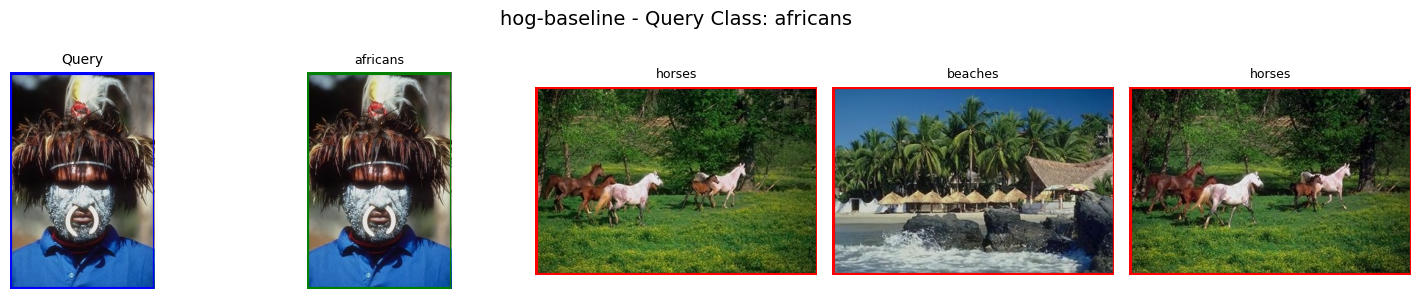


Menampilkan Top-K untuk glcm-baseline:


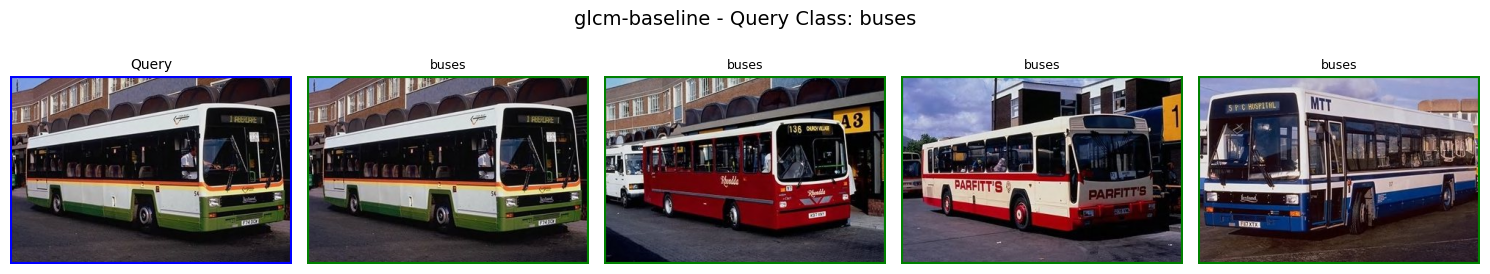


Menampilkan Top-K untuk gist-baseline:


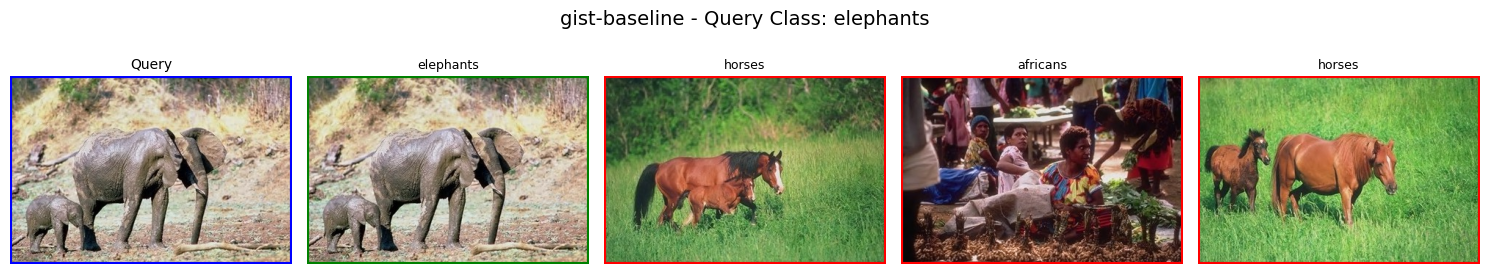

In [28]:
for m_name, feats in features_dict.items():
    model_label = f"{m_name}-baseline"
    print(f"\nMenampilkan Top-K untuk {model_label}:")
    query_idx = random.randint(0, len(labels) - 1)

    show_topk_cbir(
        features=feats,
        labels=labels,
        img_paths=img_paths,
        top_k=4,
        model_name=model_label,
        query_idx=query_idx
    )

### Tahap 4: Model Evaluation

In [29]:
# Utility
def to_numpy(x: np.ndarray) -> np.ndarray:
    """
    Ensure float32 numpy array
    """
    return np.asarray(x, dtype=np.float32)


# Measure inference speed (classical encoders)
def measure_inference_speed_batch_classical(
    model_name: str,
    img_paths: List[str],
    batch_size: int = 32
) -> float:
    """
    Measure average feature extraction time per image.
    """

    times: List[float] = []

    for i in tqdm(
        range(0, len(img_paths), batch_size),
        desc=f"Processing {model_name} batches"
    ):
        batch_imgs = [
            Image.open(p).convert("RGB")
            for p in img_paths[i:i + batch_size]
        ]

        start = time.time()
        for img in batch_imgs:
            _ = context_encoders[model_name].forward(img)
        end = time.time()

        times.append((end - start) / len(batch_imgs))

    return float(np.mean(times))


# Measure embedding-level metrics
def measure_embedding_metrics(
    features: np.ndarray,    # shape (N, D)
    labels: np.ndarray       # shape (N,)
) -> Tuple[float, float, float]:
    """
    Compute:
    - cosine similarity matrix computation time
    - mean inter-class similarity
    - mean intra-class similarity
    """

    features = to_numpy(features)
    labels = np.asarray(labels, dtype=str)

    # similarity computation time
    start = time.time()
    sims = cosine_similarity(features, features)
    search_time = time.time() - start

    classes = np.unique(labels)
    inter_dists: List[float] = []
    intra_dists: List[float] = []

    # inter-class similarity
    for i, cls_i in enumerate(classes):
        idx_i = np.where(labels == cls_i)[0]
        for j, cls_j in enumerate(classes):
            if i >= j:
                continue
            idx_j = np.where(labels == cls_j)[0]

            inter_dists.append(
                float(np.mean(sims[np.ix_(idx_i, idx_j)]))
            )

    # intra-class similarity
    for cls in classes:
        idx = np.where(labels == cls)[0]
        intra_dists.append(
            float(np.mean(sims[np.ix_(idx, idx)]))
        )

    return (
        float(search_time),
        float(np.mean(inter_dists)),
        float(np.mean(intra_dists))
    )


# Run metrics for all classical baselines
results: List[Dict[str, float | str]] = []

labels_np = np.asarray(labels, dtype=str)

for m_name, feats in features_dict.items():
    print(f"Processing {m_name}-baseline ...")

    # 1) inference speed
    avg_inf_time = measure_inference_speed_batch_classical(
        model_name=m_name,
        img_paths=img_paths,
        batch_size=32
    )

    # 2) embedding metrics
    search_time, inter, intra = measure_embedding_metrics(
        feats,
        labels_np
    )

    results.append({
        "Model": f"{m_name}-baseline",
        "Inference speed (s/img)": avg_inf_time,
        "Embedding search time (s)": search_time,
        "Inter-class similarity": inter,
        "Intra-class similarity": intra
    })


df_metrics = pd.DataFrame(results)
display(df_metrics)

Processing hog-baseline ...


Processing hog batches:   0%|          | 0/32 [00:00<?, ?it/s]

Processing hog batches: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Processing glcm-baseline ...


Processing glcm batches: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]


Processing gist-baseline ...


Processing gist batches: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


,Model,Inference speed (s/img),Embedding search time (s),Inter-class similarity,Intra-class similarity
0,hog-baseline,0.005812,0.039765,0.749133,0.781860
1,glcm-baseline,0.003859,0.006546,0.979891,0.987663
2,gist-baseline,0.004917,0.002114,0.880657,0.919488


In [ ]:
classes = sorted(np.unique(labels).tolist())


df_table = pd.DataFrame()
df_table["Class"] = classes


for m_name, df_eval in eval_results.items():
    col_prefix = f"{m_name}-baseline"

    df_eval_clean = df_eval[df_eval["Class"] != "Mean"].reset_index(drop=True)

    df_table[f"{col_prefix} Recall@10"] = df_eval_clean["Recall@K"].astype(float)
    df_table[f"{col_prefix} Precision@10"] = df_eval_clean["Precision@K"].astype(float)

mean_row: Dict[str, object] = {"Class": "Mean"}

for col in df_table.columns[1:]:
    mean_row[col] = df_table[col].mean()

df_table = pd.concat(
    [df_table, pd.DataFrame([mean_row])],
    ignore_index=True
)


# Formatting
for col in df_table.columns[1:]:
    df_table[col] = df_table[col].map("{:.4f}".format)


display(df_table)

,Class,hog-baseline Recall@10,hog-baseline Precision@10,glcm-baseline Recall@10,glcm-baseline Precision@10,gist-baseline Recall@10,gist-baseline Precision@10
0,africans,0.0137,0.1370,0.0334,0.3340,0.0268,0.2680
1,beaches,0.0164,0.1640,0.0303,0.3030,0.0218,0.2180
2,buildings,0.0162,0.1620,0.0339,0.3390,0.0298,0.2980
3,buses,0.0642,0.6420,0.0809,0.8090,0.0497,0.4970
4,dinosaurs,0.0661,0.6610,0.0747,0.7470,0.0318,0.3180
5,elephants,0.0250,0.2500,0.0422,0.4220,0.0296,0.2960
6,flowers,0.0229,0.2290,0.0756,0.7560,0.0518,0.5180
7,food,0.0161,0.1610,0.0473,0.4730,0.0209,0.2090
8,horses,0.0882,0.8820,0.0536,0.5360,0.0178,0.1780
9,mountains,0.0197,0.1970,0.0301,0.3010,0.0217,0.2170


In [32]:
print("Available models:", features_dict.keys())

for model in features_dict:
    print(model, "->", f"{len(features_dict[model])} feature vectors")

Available models: dict_keys(['hog', 'glcm', 'gist'])
hog -> 1000 feature vectors
glcm -> 1000 feature vectors
gist -> 1000 feature vectors


## Dataset: GHIM-10K

### Tahap 1: Model Initialization

### Tahap 2: Feature Extraction (JOINT-EMBEDDING MODELS INITIALIZATION)

### Tahap 3: Image Retrieval & Similarity Matching

### Tahap 4: Model Evaluation